In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
from pandas.errors import SettingWithCopyWarning

# Suppress that specific pandas warning:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# 1. LOAD & SORT
# ---------------------------------------------------
market_risk = (
    pd.read_csv("QQQ_MarketRisk.csv", parse_dates=["Date"])
    .sort_values("Date")
    .reset_index(drop=True)
)
market_risk.head()

,Date,QQQ_Return,QQQ_Realized_Volatility,QQQ_Volume,VIX,RSI_14,VXN,FedRate
0,2018-02-22,-0.000121,0.283918,37074400,18.719999,45.694866,20.910000,1.605
1,2018-02-23,0.020449,0.292777,50096900,16.490000,54.847444,18.160000,1.605
2,2018-02-26,0.013260,0.296290,39266700,15.800000,68.915674,18.120001,1.608
3,2018-02-27,-0.012383,0.294652,42209900,18.590000,59.841920,20.490000,1.635
4,2018-02-28,-0.006417,0.294987,42936300,19.850000,61.921096,22.010000,1.618


> Placing the rows in strict chronological order guarantees that every later split (train/validation/test) respects the flow of time, so information from the future never leaks into the past.

In [3]:
print(market_risk.info())
print("\n")
print(market_risk.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1725 non-null   datetime64[ns]
 1   QQQ_Return               1725 non-null   float64       
 2   QQQ_Realized_Volatility  1725 non-null   float64       
 3   QQQ_Volume               1725 non-null   int64         
 4   VIX                      1725 non-null   float64       
 5   RSI_14                   1725 non-null   float64       
 6   VXN                      1725 non-null   float64       
 7   FedRate                  1725 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 107.9 KB
None


Date                       0
QQQ_Return                 0
QQQ_Realized_Volatility    0
QQQ_Volume                 0
VIX                        0
RSI_14                     0
VXN                        0
Fed

In [4]:
# 2. FEATURE ENGINEERING
# ---------------------------------------------------
market_risk["NextVol"] = market_risk["QQQ_Realized_Volatility"].shift(-1)
market_risk = market_risk.dropna(subset=["NextVol"])
market_risk.head()

,Date,QQQ_Return,QQQ_Realized_Volatility,QQQ_Volume,VIX,RSI_14,VXN,FedRate,NextVol
0,2018-02-22,-0.000121,0.283918,37074400,18.719999,45.694866,20.910000,1.605,0.292777
1,2018-02-23,0.020449,0.292777,50096900,16.490000,54.847444,18.160000,1.605,0.296290
2,2018-02-26,0.013260,0.296290,39266700,15.800000,68.915674,18.120001,1.608,0.294652
3,2018-02-27,-0.012383,0.294652,42209900,18.590000,59.841920,20.490000,1.635,0.294987
4,2018-02-28,-0.006417,0.294987,42936300,19.850000,61.921096,22.010000,1.618,0.298916


> The one-day forward shift means every row now carries tomorrow’s realised volatility. This is the single line where the whole project’s objective—predicting next-day volatility—is encoded.

In [5]:
# 3. SELECT & CLEAN PREDICTORS
# ---------------------------------------------------
features = [
    "QQQ_Return",
    "QQQ_Realized_Volatility",
    "QQQ_Volume",
    "VIX",
    "RSI_14",
    "VXN",
    "FedRate",
]
for col in features:
    market_risk[col] = pd.to_numeric(market_risk[col], errors="coerce")
market_risk = market_risk.dropna(subset=features)

X = market_risk[features]
y_reg = market_risk["NextVol"]

> The chosen predictors combine QQQ-specific information with broader risk gauges (VIX, VXN, Fed funds proxy) and a momentum oscillator (RSI-14). They mirror the presentation’s recommendation to let XGBoost capture “complex, non-linear relationships in the data”

In [6]:
# 4. CHRONOLOGICAL 70/20/10 SPLIT
# ---------------------------------------------------
n = len(market_risk)
n_train = int(n * 0.70)
n_val = int(n * 0.20)
n_test = n - n_train - n_val

X_train = X.iloc[:n_train]
X_val = X.iloc[n_train : n_train + n_val]
X_test = X.iloc[n_train + n_val :]

y_reg_train = y_reg.iloc[:n_train]
y_reg_val = y_reg.iloc[n_train : n_train + n_val]
y_reg_test = y_reg.iloc[n_train + n_val :]

print(f"Train:      {n_train} rows ({n_train/n*100:.1f}%)")
print(f"Validation: {n_val} rows ({n_val/n*100:.1f}%)")
print(f"Test:       {n_test} rows ({n_test/n*100:.1f}%)")

Train:      1206 rows (70.0%)
Validation: 344 rows (20.0%)
Test:       174 rows (10.1%)


In [7]:
# 5. XGBOOST REGRESSOR (Volatility Forecast)
# ---------------------------------------------------
reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=50,
    learning_rate=0.05,
    random_state=42,
)

# Fit with eval_set to capture learning curves
gb_reg = reg.fit(
    X_train,
    y_reg_train,
    eval_set=[(X_train, y_reg_train), (X_val, y_reg_val)],
    verbose=False,
)

y_reg_pred = gb_reg.predict(X_test)

# Regression metrics
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)
mae = mean_absolute_error(y_reg_test, y_reg_pred)
print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test R²  : {r2:.4f}")
print(f"Test MAE : {mae:.6f}")

# Prepare for diagnostic plots
residuals = y_reg_test - y_reg_pred
test_dates = market_risk["Date"].iloc[n_train + n_val :]

Test MSE : 0.000234
Test RMSE: 0.015300
Test R²  : 0.9164
Test MAE : 0.011915


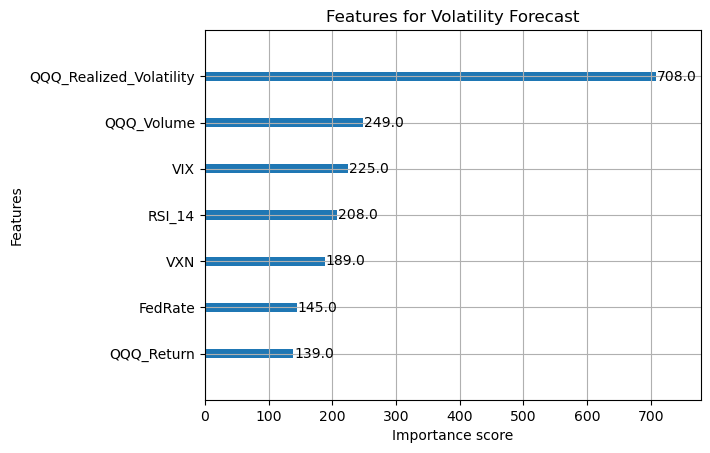

In [8]:
# 6. FEATURE IMPORTANCE
# ---------------------------------------------------
xgb.plot_importance(gb_reg, max_num_features=7)
plt.title("Features for Volatility Forecast")
plt.show()

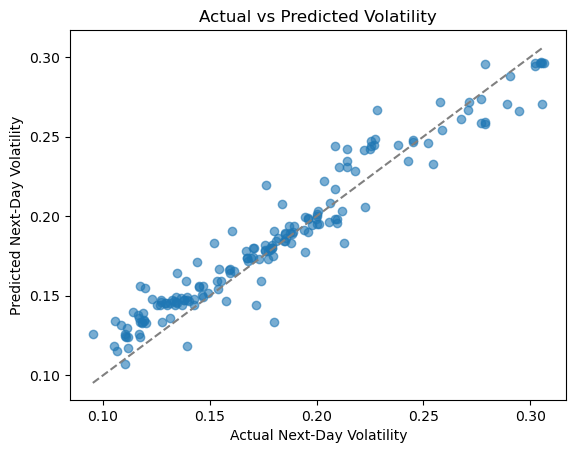

In [9]:
# 1. Actual vs Predicted Scatter
plt.figure()
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
lims = [
    min(y_reg_test.min(), y_reg_pred.min()),
    max(y_reg_test.max(), y_reg_pred.max()),
]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Actual Next-Day Volatility")
plt.ylabel("Predicted Next-Day Volatility")
plt.title("Actual vs Predicted Volatility")
plt.show()

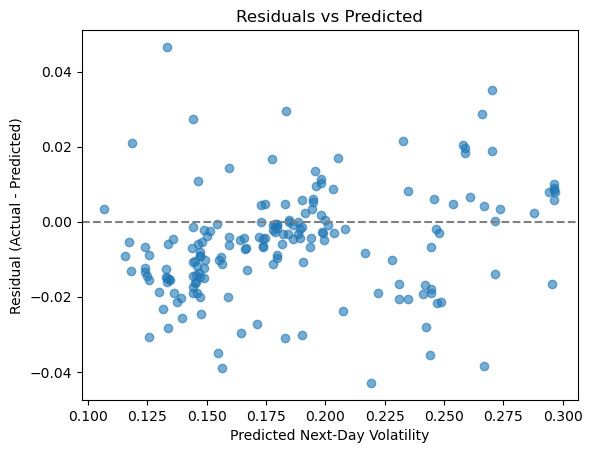

In [10]:
# 2. Residuals vs Predicted
plt.figure()
plt.scatter(y_reg_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicted Next-Day Volatility")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

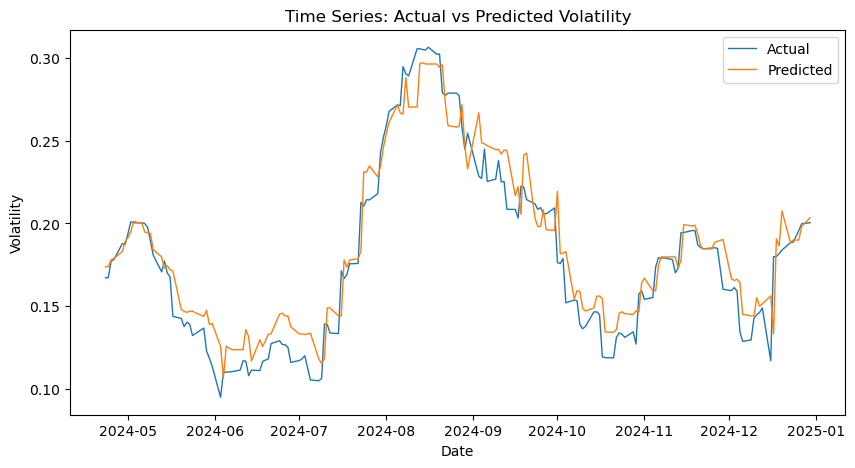

In [11]:
# 3. Time Series Overlay (wider)
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_reg_test.values, label="Actual", linewidth=1)
plt.plot(test_dates, y_reg_pred, label="Predicted", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Time Series: Actual vs Predicted Volatility")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_reg_test, y_reg_pred)
print(f"MAPE: {mape:.2%}")

MAPE: 7.49%


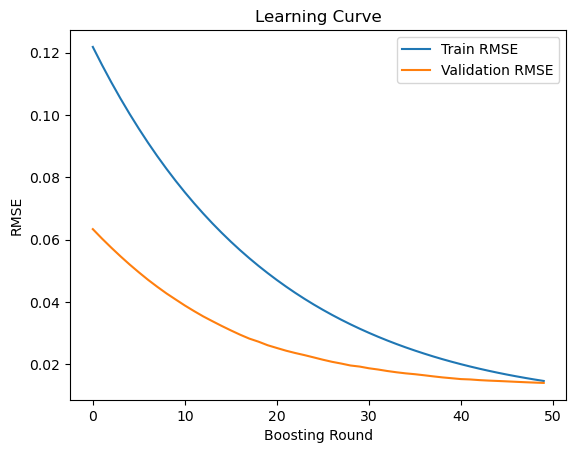

In [14]:
# 4. Learning Curves
evals_result = gb_reg.evals_result()
plt.figure()
plt.plot(evals_result["validation_0"]["rmse"], label="Train RMSE")
plt.plot(evals_result["validation_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()

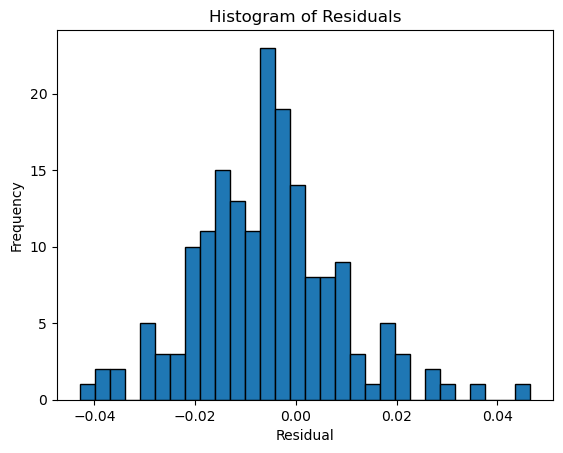

In [15]:
# 5. Histogram of Residuals
plt.figure()
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

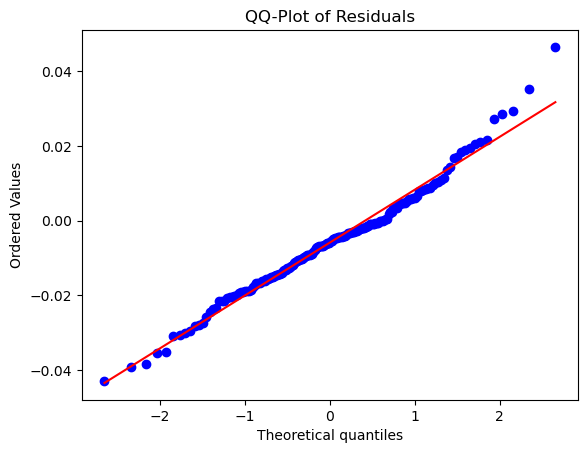

In [16]:
# 6. QQ-Plot of Residuals
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.show()

In [19]:
# -----------------------------------------------------------
#  A)  REGIME-BASED STRESS-TEST
# -----------------------------------------------------------
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np  # already imported earlier, but safe to repeat

# --- fit a quick OLS baseline --------------------------------
lin = LinearRegression()
lin.fit(X_train, y_reg_train)  # uses splits you created earlier

# --- 1. rows in the TEST window ------------------------------
test_mask = market_risk.index.isin(X_test.index)

# --- 2. volatility regimes -----------------------------------
high_vix = test_mask & (market_risk["VIX"] > 30)  # panic
low_vix = test_mask & (market_risk["VIX"] < 15)  # calm


def eval_subset(mask: pd.Series, name: str) -> None:
    """
    Print RMSE, MAE, R² for both models on the chosen subset.
    Works with older scikit-learn (no 'squared=' arg).
    """
    y_true = y_reg.loc[mask]
    if y_true.empty:
        print(f"{name:>6} | - no rows in subset -")
        return

    # predictions
    y_lin = lin.predict(X.loc[mask])
    y_xgb = gb_reg.predict(X.loc[mask])

    for label, pred in [("Linear", y_lin), ("XGBoost", y_xgb)]:
        mse = mean_squared_error(y_true, pred)  # plain MSE
        rmse = np.sqrt(mse)  # manual √
        mae = mean_absolute_error(y_true, pred)
        r2 = r2_score(y_true, pred)
        print(
            f"{name:>6} | {label:<8}  RMSE: {rmse:.6f}  MAE: {mae:.6f}  R²: {r2: .3f}"
        )


print("\n---  Stress-test results  -------------------------------")
eval_subset(high_vix, "VIX>30")
eval_subset(low_vix, "VIX<15")


---  Stress-test results  -------------------------------
VIX>30 | Linear    RMSE: 0.020765  MAE: 0.020765  R²:  nan
VIX>30 | XGBoost   RMSE: 0.000053  MAE: 0.000053  R²:  nan
VIX<15 | Linear    RMSE: 0.010891  MAE: 0.006989  R²:  0.924
VIX<15 | XGBoost   RMSE: 0.014773  MAE: 0.011790  R²:  0.860


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



Ensemble weights from validation:  w_OLS=0.55,  w_XGB=0.45

---  Hybrid performance on TEST set  ---------------------
OLS       RMSE: 0.011946  R²:  0.949
XGBoost   RMSE: 0.015300  R²:  0.916
Switch    RMSE: 0.011841  R²:  0.950
Blend     RMSE: 0.012819  R²:  0.941

---  Stress-test by regime  -----------------------------

VIX>30
  OLS       RMSE: 0.020765  R²:  nan
  XGBoost   RMSE: 0.000053  R²:  nan
  Switch    RMSE: 0.000053  R²:  nan
  Blend     RMSE: 0.011469  R²:  nan

VIX<15
  OLS       RMSE: 0.010891  R²:  0.924
  XGBoost   RMSE: 0.014773  R²:  0.860
  Switch    RMSE: 0.010891  R²:  0.924
  Blend     RMSE: 0.012052  R²:  0.907


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


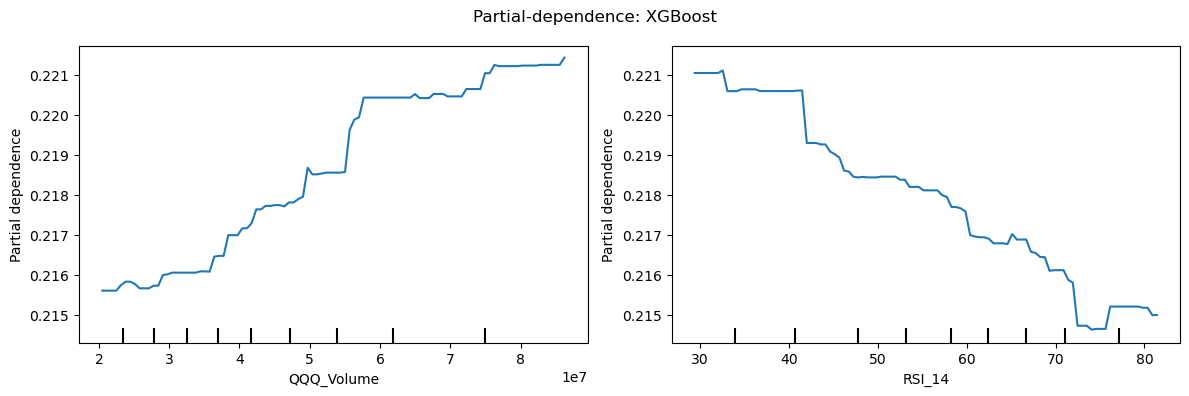

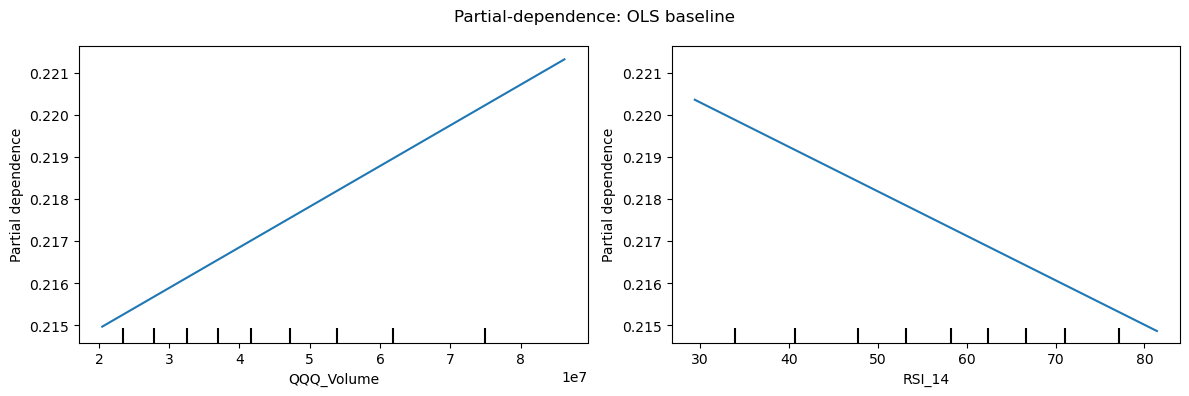

In [22]:
# -----------------------------------------------------------
#  A)  HYBRID REGIME-TEST & BLEND
# -----------------------------------------------------------
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay

# 1.  Standalone predictions
ols_full = lin.predict(X)  # OLS on every row
xgb_full = gb_reg.predict(X)  # XGBoost on every row

# 2.  Regime-switch: use XGB when VIX ≥ 30, else OLS
tau = 30
vix = market_risk["VIX"]
switch_full = np.where(vix >= tau, xgb_full, ols_full)

# 3.  Weighted blend: weight ∝ inverse validation MAE
mae_ols = mean_absolute_error(y_reg_val, lin.predict(X_val))
mae_xgb = mean_absolute_error(y_reg_val, gb_reg.predict(X_val))
w_xgb = mae_ols / (mae_ols + mae_xgb)
w_ols = 1 - w_xgb
blend_full = w_xgb * xgb_full + w_ols * ols_full

print(f"\nEnsemble weights from validation:  w_OLS={w_ols:.2f},  w_XGB={w_xgb:.2f}")


# 4.  Function to evaluate on TEST set
def evaluate(name, preds):
    y_hat = preds[X_test.index]
    mse = mean_squared_error(y_reg_test, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg_test, y_hat)
    print(f"{name:<8}  RMSE: {rmse:.6f}  R²: {r2: .3f}")


print("\n---  Hybrid performance on TEST set  ---------------------")
evaluate("OLS", pd.Series(ols_full, index=X.index))
evaluate("XGBoost", pd.Series(xgb_full, index=X.index))
evaluate("Switch", pd.Series(switch_full, index=X.index))
evaluate("Blend", pd.Series(blend_full, index=X.index))

# 5.  Regime-based stress-test for all four
test_mask = market_risk.index.isin(X_test.index)
high_vix = test_mask & (market_risk["VIX"] > 30)
low_vix = test_mask & (market_risk["VIX"] < 15)

print("\n---  Stress-test by regime  -----------------------------")
for regime_mask, label in [(high_vix, "VIX>30"), (low_vix, "VIX<15")]:
    print(f"\n{label}")
    for name, preds in [
        ("OLS", ols_full),
        ("XGBoost", xgb_full),
        ("Switch", switch_full),
        ("Blend", blend_full),
    ]:
        y_hat = preds[regime_mask]
        y_true = y_reg[regime_mask]
        if y_true.empty:
            print(f"  {name:<8}  no test rows")
            continue
        mse = mean_squared_error(y_true, y_hat)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_hat)
        print(f"  {name:<8}  RMSE: {rmse:.6f}  R²: {r2: .3f}")

# -----------------------------------------------------------
#  B)  PARTIAL-DEPENDENCE CURVES (PDP)
# -----------------------------------------------------------
pdp_features = ["QQQ_Volume", "RSI_14"]

# XGBoost PDP
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    gb_reg, X, pdp_features, ax=ax, kind="average", n_jobs=-1
)
fig.suptitle("Partial-dependence: XGBoost")
plt.tight_layout()

# OLS PDP
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(lin, X, pdp_features, ax=ax, kind="average")
fig.suptitle("Partial-dependence: OLS baseline")
plt.tight_layout()